In [ ]:
!pip install --upgrade tensorflow

In [ ]:
from google.colab import drive #Importar la base de datos desde el drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Instanciando la red pre-entrenada EfficientNetV2B0 para aplicarla a la BD con expansión de imágenes pero esta vez con entonación fina

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import statistics
import pydot
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#Se importa la red neuronal efficientnet_v2 de keras
conv_base  = keras.applications.efficientnet_v2.EfficientNetV2B0(
    weights="imagenet",#se trae con los pesos del dataset previo
    include_top=False) #se coloca para no utilizar la ultima capa y uno poder entrenar una propia suya

24274472/24274472 [==============================] - 1s 0us/step


In [ ]:
!unzip /content/gdrive/MyDrive/TRABAJOGRADO/TRABAJO/Database3.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: Database3/Train/nv/ISIC_0026937.jpg  
  inflating: Database3/Train/nv/ISIC_0026939.jpg  
  inflating: Database3/Train/nv/ISIC_0026942.jpg  
  inflating: Database3/Train/nv/ISIC_0026943.jpg  
  inflating: Database3/Train/nv/ISIC_0026945.jpg  
  inflating: Database3/Train/nv/ISIC_0026946.jpg  
  inflating: Database3/Train/nv/ISIC_0026949.jpg  
  inflating: Database3/Train/nv/ISIC_0026971.jpg  
  inflating: Database3/Train/nv/ISIC_0026973.jpg  
  inflating: Database3/Train/nv/ISIC_0026974.jpg  
  inflating: Database3/Train/nv/ISIC_0026977.jpg  
  inflating: Database3/Train/nv/ISIC_0026979.jpg  
  inflating: Database3/Train/nv/ISIC_0026980.jpg  
  inflating: Database3/Train/nv/ISIC_0026982.jpg  
  inflating: Database3/Train/nv/ISIC_0026983.jpg  
  inflating: Database3/Train/nv/ISIC_0026985.jpg  
  inflating: Database3/Train/nv/ISIC_0026994.jpg  
  inflating: Database3/Train/nv/ISIC_0026997.jpg  
  inflating: Database

Ajustando los datos de la BD


In [ ]:
train_dataset = image_dataset_from_directory(
    'Database3/Train',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)
validation_dataset = image_dataset_from_directory(
    'Database3/Train_val',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)
test_dataset = image_dataset_from_directory(
    'Database3/Test',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)

Found 5284 files belonging to 4 classes.
Found 2263 files belonging to 4 classes.
Found 1884 files belonging to 4 classes.


La fase de entrenamiento podrá alterar los pesos de las 4 últimas capas

In [ ]:
#conv_base.trainable = False #Congela los pesos y TRUE para ser entrenable

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False #codigo para que sea entrenable cierta cantidad de capaz

In [ ]:
conv_base.summary() #Ver el resumen del modelo

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

Transformaciones para expandir las imágenes y definición de la arquitectura


In [ ]:
#Aumento de datos
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.efficientnet_v2.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(385, kernel_regularizer=regularizers.l1_l2(0.001), activation="elu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       7         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 flatten_1 (Flatten)         (None, 46080)             0         
                                                                 
 dense_2 (Dense)             (None, 952)               43869112  
                                                                 
 batch_normalization_1 (Bat  (None, 952)               3808      
 chNormalization)                                          

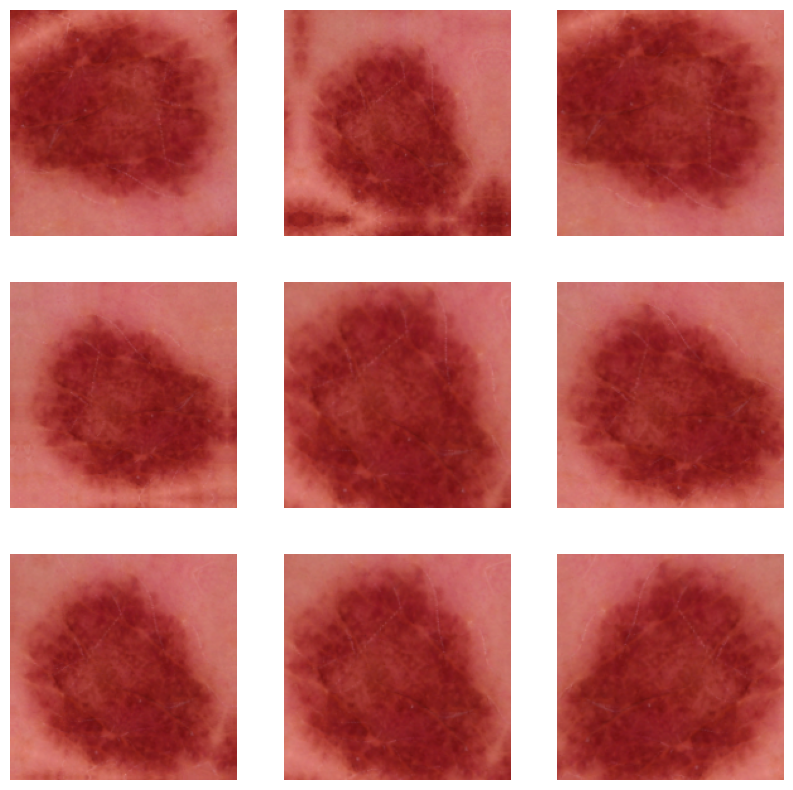

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Fijar los hiperparámetros y entrenar la red

In [ ]:
from keras.callbacks import EarlyStopping
checkpoint_filepath = 'bestmodel.h5'

model.compile(loss="categorical_crossentropy", #funcion de perdida para problemas de clasificacion
              optimizer=keras.optimizers.Adam(learning_rate=1e-3),  #Utilizar Adam
              metrics=["accuracy"])

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10),

    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=10,
        verbose=1,
        min_lr=1e-12),

    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
]

history = model.fit(
    train_dataset,
    epochs=1000,
    batch_size=32,
    validation_data=validation_dataset,
    verbose=1,
    callbacks=callbacks_list
)


Epoch 1/1000
166/166 [==============================] - 33s 99ms/step - loss: 40.4466 - accuracy: 0.6240 - val_loss: 14.8593 - val_accuracy: 0.6522 - lr: 0.0010
Epoch 2/1000
166/166 [==============================] - 14s 81ms/step - loss: 11.8275 - accuracy: 0.7034 - val_loss: 11.5080 - val_accuracy: 0.7176 - lr: 0.0010
Epoch 3/1000
166/166 [==============================] - 14s 82ms/step - loss: 10.5425 - accuracy: 0.7369 - val_loss: 10.1799 - val_accuracy: 0.7362 - lr: 0.0010
Epoch 4/1000
166/166 [==============================] - 14s 82ms/step - loss: 9.9341 - accuracy: 0.7487 - val_loss: 11.4915 - val_accuracy: 0.7649 - lr: 0.0010
Epoch 5/1000
166/166 [==============================] - 13s 79ms/step - loss: 10.5863 - accuracy: 0.7646 - val_loss: 9.8270 - val_accuracy: 0.7154 - lr: 0.0010
Epoch 6/1000
166/166 [==============================] - 14s 80ms/step - loss: 9.4786 - accuracy: 0.7657 - val_loss: 9.4067 - val_accuracy: 0.6951 - lr: 0.0010
Epoch 7/1000
166/166 [================

Visualizando la pérdida y el accuracy durante el entrenamiento


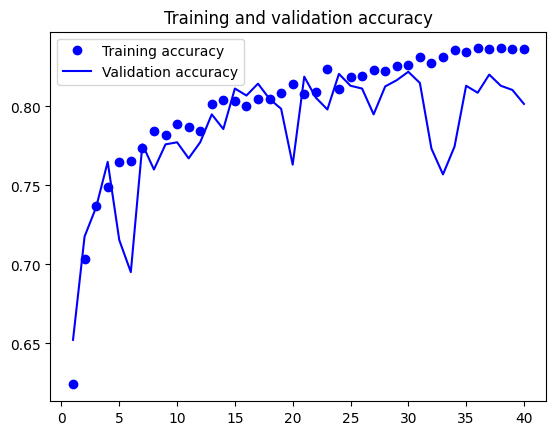

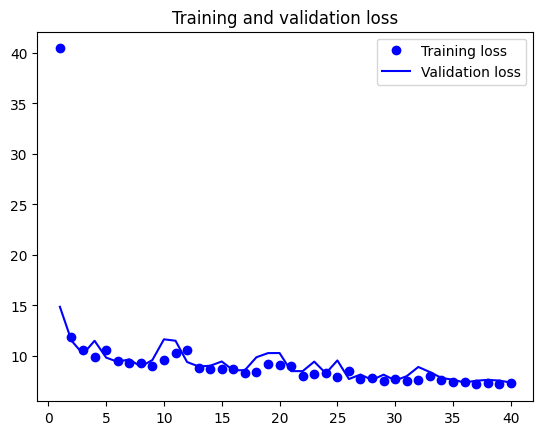

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
print("--------------------------Test Results------------------------")
test_scores = model.evaluate(test_dataset, verbose=2)
print("Test Loss:", test_scores[0])
print("Test Accuracy:", test_scores[1])

--------------------------Test Results------------------------
59/59 - 3s - loss: 7.3582 - accuracy: 0.8084 - 3s/epoch - 56ms/step
Test Loss: 7.3582353591918945
Test Accuracy: 0.8083863854408264


1/1 [==============================] - 0s 30ms/step


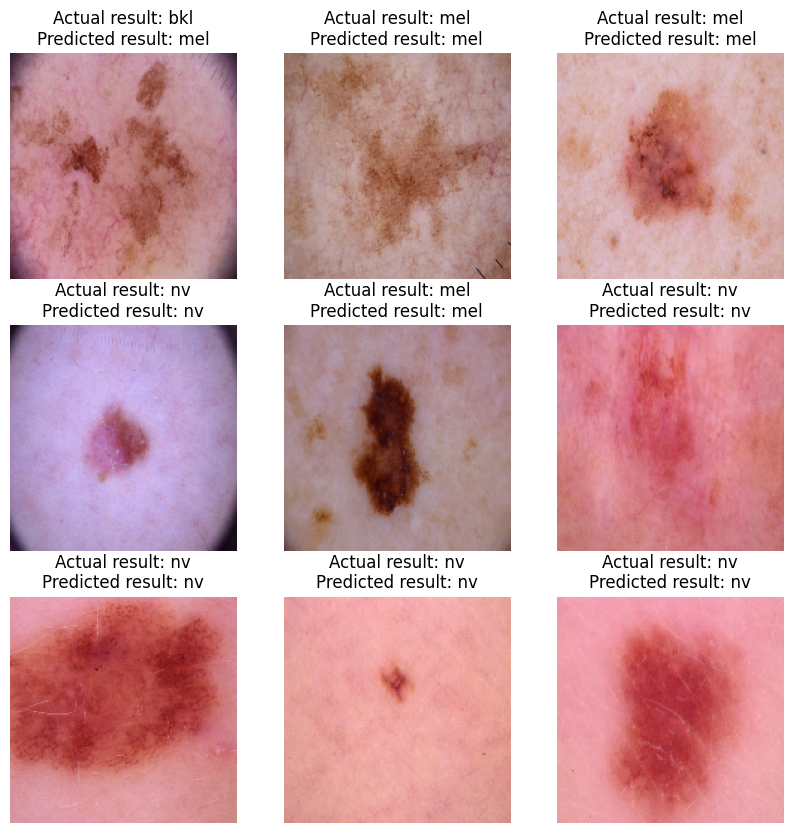

In [ ]:
class_names = test_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    results = model.predict(images)
    max_prob = max(results[i])
    class_ind = list(results[i]).index(max_prob)
    class_name = labels[class_ind]
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("Actual result: " + class_names[np.argmax(labels[i],axis=-1)] + "\n" + "Predicted result: " + class_names[np.argmax(class_name,axis=-1)])
    plt.axis("off")

### Matriz de confusión y métricas relevantes

In [ ]:
import numpy as np

In [ ]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
predicciones_train = []  # store predicted labels
labels_train = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in train_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_train.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_train.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 2s 2s/step


In [ ]:
ultimo_label_train = labels_train.pop()
ultima_prediccion_train = predicciones_train.pop()

labels_train = np.array([np.argmax(i, axis = - 1) for i in labels_train]).flatten()
predicciones_train = np.array(predicciones_train).flatten()

ultimo_label_train = np.array([np.argmax(i, axis = - 1) for i in ultimo_label_train]).flatten()
labels_train = np.concatenate((labels_train, ultimo_label_train))
predicciones_train = np.concatenate((predicciones_train, ultima_prediccion_train))

[[ 176   61   34   18]
 [   7  499   52   58]
 [   0   82  359  183]
 [  10  166  101 3478]]


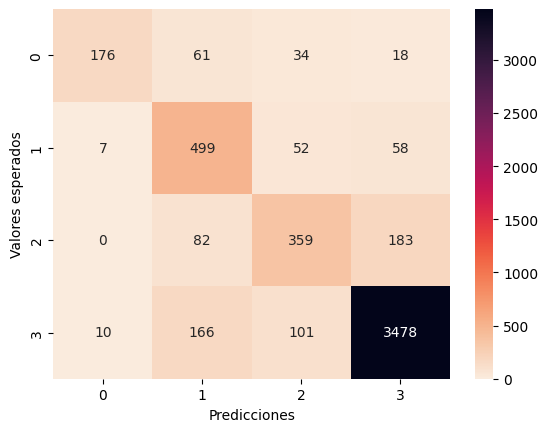

              precision    recall  f1-score   support

           0       0.91      0.61      0.73       289
           1       0.62      0.81      0.70       616
           2       0.66      0.58      0.61       624
           3       0.93      0.93      0.93      3755

    accuracy                           0.85      5284
   macro avg       0.78      0.73      0.74      5284
weighted avg       0.86      0.85      0.85      5284



In [ ]:
#predicciones_test = model.predict(images_test)
import matplotlib.pyplot as plt
import seaborn as sns

cf = metrics.confusion_matrix(labels_train,predicciones_train)
print(cf)
## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
sns.heatmap(cf, annot=True, fmt="g", cmap=sns.color_palette("rocket_r",as_cmap=True))
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')

## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_train,predicciones_train))

In [ ]:
validation_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
predicciones_val_train = []  # store predicted labels
labels_val_train = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in validation_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_val_train.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_val_train.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 0s 27ms/step


In [ ]:
ultimo_label_val_train = labels_val_train.pop()
ultima_prediccion_val_train = predicciones_val_train.pop()

labels_val_train = np.array([np.argmax(i, axis = - 1) for i in labels_val_train]).flatten()
predicciones_val_train = np.array(predicciones_val_train).flatten()

labels_val_train = np.concatenate((labels_val_train, np.argmax(ultimo_label_val_train, axis = - 1)))
predicciones_val_train = np.concatenate((predicciones_val_train, ultima_prediccion_val_train))

[[  63   33   18    9]
 [   3  191   28   42]
 [   3   50  119   95]
 [   6   90   72 1441]]


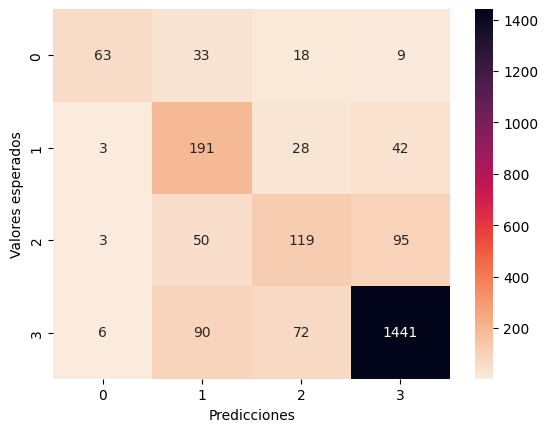

              precision    recall  f1-score   support

           0       0.84      0.51      0.64       123
           1       0.52      0.72      0.61       264
           2       0.50      0.45      0.47       267
           3       0.91      0.90      0.90      1609

    accuracy                           0.80      2263
   macro avg       0.69      0.64      0.65      2263
weighted avg       0.81      0.80      0.80      2263



In [ ]:
#predicciones_test = model.predict(images_test)

cf = metrics.confusion_matrix(labels_val_train,predicciones_val_train)
print(cf)
## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
sns.heatmap(cf, annot=True, fmt="g", cmap=sns.color_palette("rocket_r",as_cmap=True))
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')

## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_val_train,predicciones_val_train))

In [ ]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
predicciones_test = []  # store predicted labels
labels_test = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_test.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_test.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 0s 32ms/step


In [ ]:
ultimo_label_test = labels_test.pop()
ultima_prediccion_test = predicciones_test.pop()

labels_test = np.array([np.argmax(i, axis = - 1) for i in labels_test]).flatten()
predicciones_test = np.array(predicciones_test).flatten()

labels_test = np.concatenate((labels_test, np.argmax(ultimo_label_test, axis = - 1)))
predicciones_test = np.concatenate((predicciones_test, ultima_prediccion_test))

[[  54   28   12    8]
 [   1  163   29   26]
 [   1   39  102   80]
 [   5   82   50 1204]]


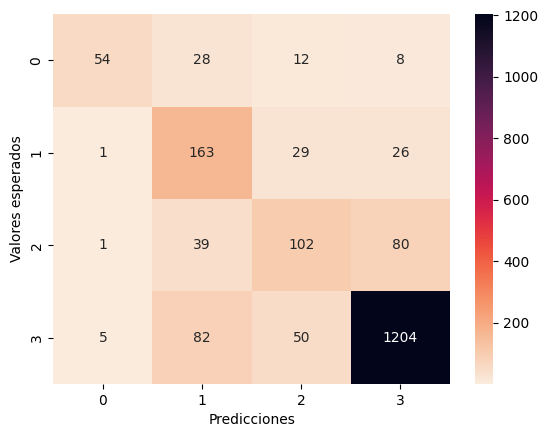

              precision    recall  f1-score   support

           0       0.89      0.53      0.66       102
           1       0.52      0.74      0.61       219
           2       0.53      0.46      0.49       222
           3       0.91      0.90      0.91      1341

    accuracy                           0.81      1884
   macro avg       0.71      0.66      0.67      1884
weighted avg       0.82      0.81      0.81      1884



In [ ]:
#predicciones_test = model.predict(images_test)

cf = metrics.confusion_matrix(labels_test,predicciones_test)
print(cf)
## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
sns.heatmap(cf, annot=True, fmt="g", cmap=sns.color_palette("rocket_r",as_cmap=True))
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')

## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_test,predicciones_test))

Guardar el modelo con Tensorflow Lite para correr en Raspberry

In [ ]:
import tensorflow
# Convert the model.
converter = tensorflow.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model_EfficientNetV2B0.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
class_names = train_dataset.class_names
print(class_names)

In [ ]:
num_classes = len(class_names)

g = sns.catplot(x="dx", kind="count", palette='bright', data=file)
plt.xticks(rotation=90)
g.ax.set_title('Visualization of Output Classes', fontsize=20)
g.set_xlabels('Classes of Skin Cancer', fontsize=14)
g.set_ylabels('Frequency', fontsize=14)